# Anomaly Detection Testing

This notebook tests the anomaly detection functionality using trained autoencoder models.

In [4]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directories to path for module imports
notebook_dir = Path(os.path.abspath(''))
project_root = notebook_dir.parent.parent  # Go up two levels from notebooks/
sys.path.insert(0, str(project_root))

print("Imports successful!")
print(f"Project root: {project_root}")

Imports successful!
Project root: h:\Project_2_data_collector_uploader\IDS


## 1. Load Utilities and Data

In [5]:
from industrial_data_system.utils.asc_utils import load_and_process_asc_file
from industrial_data_system.core.db_manager import DatabaseManager

# Initialize database manager
db_manager = DatabaseManager()

print("✓ Database manager initialized")
print(f"  Database initialized successfully")

✓ Database manager initialized
  Database initialized successfully


## 2. Check Available Trained Models

In [6]:
# List all trained models in the registry
try:
    models = db_manager.get_all_models()
    
    if models:
        print(f"Found {len(models)} trained models:")
        print("\n" + "=" * 80)
        
        for i, model in enumerate(models, 1):
            print(f"\nModel {i}:")
            print(f"  ID: {model['model_id']}")
            print(f"  Name: {model['model_name']}")
            print(f"  Type: {model['model_type']}")
            print(f"  Trained: {model['created_at']}")
            print(f"  Path: {model['model_path']}")
            if model.get('metrics'):
                print(f"  Metrics: {model['metrics']}")
    else:
        print("No trained models found in the registry.")
        print("\nYou can train a model first using the training notebook or application.")
except Exception as e:
    print(f"Error accessing model registry: {e}")
    print("\nThis notebook requires trained models. Please train a model first.")

Found 39 trained models:


Model 1:
  ID: 39
  Name: V60N_Corner-power_parquet_v11
  Type: autoencoder
  Trained: 2025-12-18 10:43:17
  Path: A:\TB\Tool\Data_tests\IndustrialData\files\V60N\tests\Corner-power\model_parquet.pkl
  Metrics: {'training_loss': 0.006121616735726553, 'reconstruction_error_mean': 0.0012999748578295112, 'reconstruction_error_std': 0.015378771349787712}

Model 2:
  ID: 38
  Name: V60N_Corner-power_parquet_v10
  Type: autoencoder
  Trained: 2025-12-18 10:38:59
  Path: A:\TB\Tool\Data_tests\IndustrialData\files\V60N\tests\Corner-power\model_parquet.pkl
  Metrics: {'training_loss': 0.00019576633456926376, 'reconstruction_error_mean': 0.0001019302144413814, 'reconstruction_error_std': 0.00011196689592907205}

Model 3:
  ID: 37
  Name: V60N_Corner-power_parquet_v9
  Type: autoencoder
  Trained: 2025-12-18 10:23:12
  Path: A:\TB\Tool\Data_tests\IndustrialData\files\V60N\tests\Corner-power\model_parquet.pkl
  Metrics: {'training_loss': 0.0025943343734375645, 'reconstru

## 3. Load Test Data for Anomaly Detection

In [7]:
# Path to test ASC file
test_file = str(project_root / 'industrial_data_system' / 'Tests' / 'Data' / 'V24-2025__0011_2.ASC')

if os.path.exists(test_file):
    print(f"Loading test file: {test_file}")
    df = load_and_process_asc_file(test_file)
    print(f"✓ Loaded DataFrame shape: {df.shape}")
    print(f"✓ Columns: {df.columns.tolist()[:5]}...")
else:
    print(f"Test file not found: {test_file}")
    print("Creating synthetic test data...")
    
    # Create synthetic data with some anomalies
    n_samples = 5000
    t = np.linspace(0, 50, n_samples)
    
    # Normal operation
    pressure = 50 + 5*np.sin(2*np.pi*0.5*t) + np.random.normal(0, 0.5, n_samples)
    flow = 100 + 10*np.sin(2*np.pi*0.3*t) + np.random.normal(0, 1, n_samples)
    speed = 1500 + 50*np.sin(2*np.pi*0.2*t) + np.random.normal(0, 5, n_samples)
    
    # Inject anomalies
    anomaly_indices = [1000, 2500, 4000]
    for idx in anomaly_indices:
        pressure[idx:idx+50] += np.random.uniform(15, 25)  # Pressure spike
        flow[idx:idx+50] -= np.random.uniform(20, 40)      # Flow drop
    
    df = pd.DataFrame({
        'Messzeit[s]': t,
        'Pressure [bar]': pressure,
        'Flow [L/min]': flow,
        'Speed [rpm]': speed,
        'Torque [Nm]': 150 + 20*np.sin(2*np.pi*0.4*t) + np.random.normal(0, 2, n_samples)
    })
    
    print("✓ Created synthetic test data with injected anomalies")
    print(f"  Anomalies at indices: {anomaly_indices}")

Test file not found: h:\Project_2_data_collector_uploader\IDS\industrial_data_system\Tests\Data\V24-2025__0011_2.ASC
Creating synthetic test data...
✓ Created synthetic test data with injected anomalies
  Anomalies at indices: [1000, 2500, 4000]


## 4. Visualize Test Data

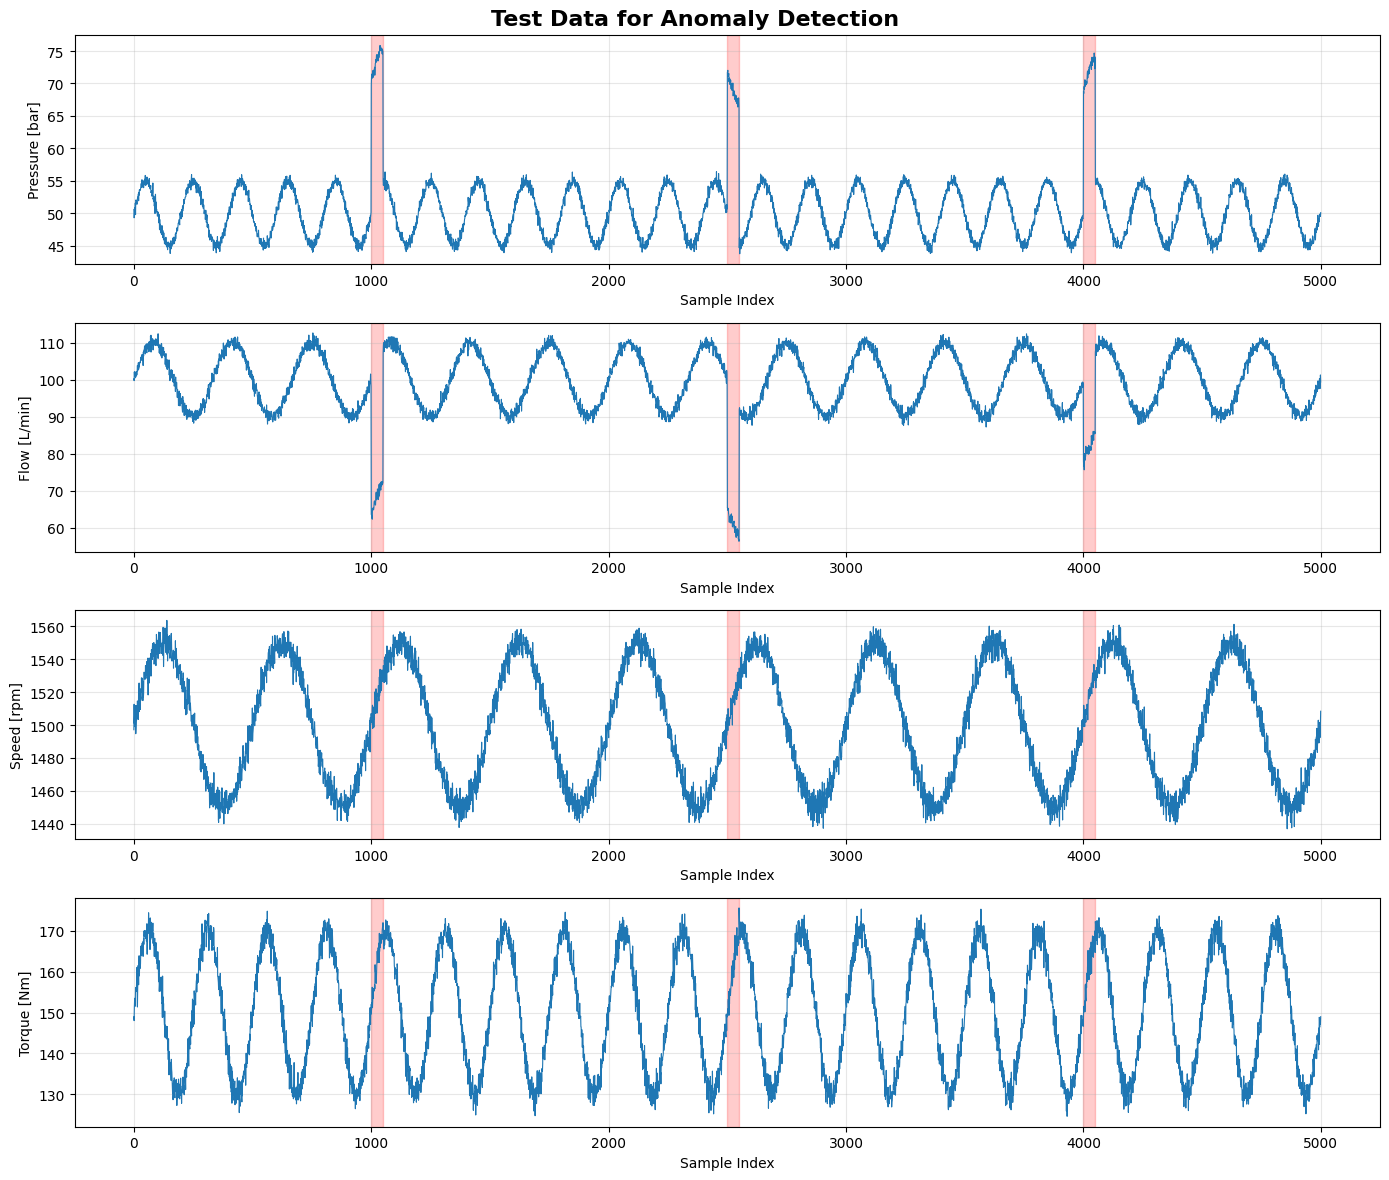

In [8]:
# Plot first 4 channels
numeric_columns = df.select_dtypes(include=[np.number]).columns
channels_to_plot = [col for col in numeric_columns if 'Messzeit' not in col][:4]

fig, axes = plt.subplots(len(channels_to_plot), 1, figsize=(14, 3*len(channels_to_plot)))

if len(channels_to_plot) == 1:
    axes = [axes]

fig.suptitle('Test Data for Anomaly Detection', fontsize=16, fontweight='bold')

for i, channel in enumerate(channels_to_plot):
    axes[i].plot(df.index, df[channel], linewidth=0.8)
    axes[i].set_ylabel(channel)
    axes[i].set_xlabel('Sample Index')
    axes[i].grid(True, alpha=0.3)
    
    # Mark known anomaly regions (if using synthetic data)
    if 'anomaly_indices' in locals():
        for idx in anomaly_indices:
            axes[i].axvspan(idx, idx+50, alpha=0.2, color='red', label='Injected Anomaly')

plt.tight_layout()
plt.show()

## 5. Simple Statistical Anomaly Detection

Test basic anomaly detection using statistical methods (z-score, IQR).

In [9]:
def detect_anomalies_zscore(data, threshold=3):
    """
    Detect anomalies using z-score method.
    
    Args:
        data: 1D array of values
        threshold: Number of standard deviations from mean
    
    Returns:
        Boolean array indicating anomalies
    """
    mean = np.mean(data)
    std = np.std(data)
    z_scores = np.abs((data - mean) / std)
    return z_scores > threshold

def detect_anomalies_iqr(data, multiplier=1.5):
    """
    Detect anomalies using IQR (Interquartile Range) method.
    
    Args:
        data: 1D array of values
        multiplier: IQR multiplier for bounds
    
    Returns:
        Boolean array indicating anomalies
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return (data < lower_bound) | (data > upper_bound)

# Test on first numeric column
test_channel = channels_to_plot[0]
test_data = df[test_channel].values

anomalies_zscore = detect_anomalies_zscore(test_data, threshold=3)
anomalies_iqr = detect_anomalies_iqr(test_data, multiplier=1.5)

print(f"Anomaly Detection Results for {test_channel}:")
print(f"  Z-score method (threshold=3): {np.sum(anomalies_zscore)} anomalies ({100*np.sum(anomalies_zscore)/len(test_data):.2f}%)")
print(f"  IQR method (multiplier=1.5): {np.sum(anomalies_iqr)} anomalies ({100*np.sum(anomalies_iqr)/len(test_data):.2f}%)")

Anomaly Detection Results for Pressure [bar]:
  Z-score method (threshold=3): 150 anomalies (3.00%)
  IQR method (multiplier=1.5): 150 anomalies (3.00%)


## 6. Visualize Statistical Anomaly Detection

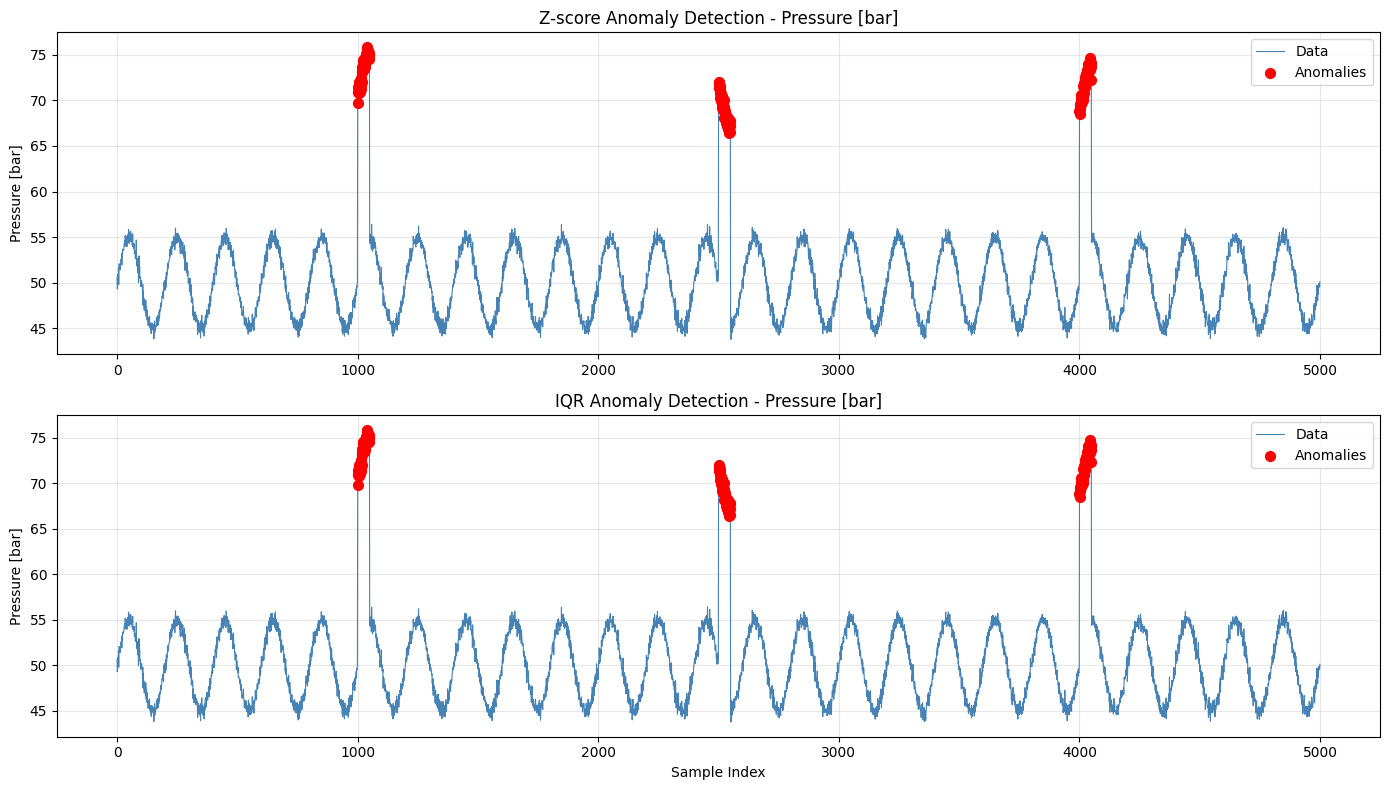

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Z-score method
axes[0].plot(test_data, linewidth=0.8, label='Data', color='steelblue')
axes[0].scatter(np.where(anomalies_zscore)[0], test_data[anomalies_zscore], 
               color='red', s=50, label='Anomalies', zorder=5)
axes[0].set_title(f'Z-score Anomaly Detection - {test_channel}')
axes[0].set_ylabel(test_channel)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# IQR method
axes[1].plot(test_data, linewidth=0.8, label='Data', color='steelblue')
axes[1].scatter(np.where(anomalies_iqr)[0], test_data[anomalies_iqr], 
               color='red', s=50, label='Anomalies', zorder=5)
axes[1].set_title(f'IQR Anomaly Detection - {test_channel}')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel(test_channel)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Load and Test Trained Model (if available)

If you have trained models, you can load and test them here.

In [11]:
import joblib

# This section requires a trained model
# You can modify the model_path to point to your trained model

model_path = None  # Set this to your model path

if model_path and os.path.exists(model_path):
    print(f"Loading model from: {model_path}")
    model = joblib.load(model_path)
    print("✓ Model loaded successfully")
    
    # Prepare data for model prediction
    # This will depend on your model's expected input format
    # Example:
    # features = df[model_features].values
    # predictions = model.predict(features)
    # reconstruction_error = np.mean((features - predictions) ** 2, axis=1)
    
else:
    print("No trained model specified.")
    print("\nTo use a trained model:")
    print("1. Train a model using the training application")
    print("2. Set model_path to the path of your trained model file")
    print("3. Rerun this cell")

No trained model specified.

To use a trained model:
1. Train a model using the training application
2. Set model_path to the path of your trained model file
3. Rerun this cell


## 8. Sliding Window Anomaly Detection

Test anomaly detection using sliding windows.

Window size 50: 114 anomalies detected
Window size 100: 47 anomalies detected
Window size 200: 48 anomalies detected


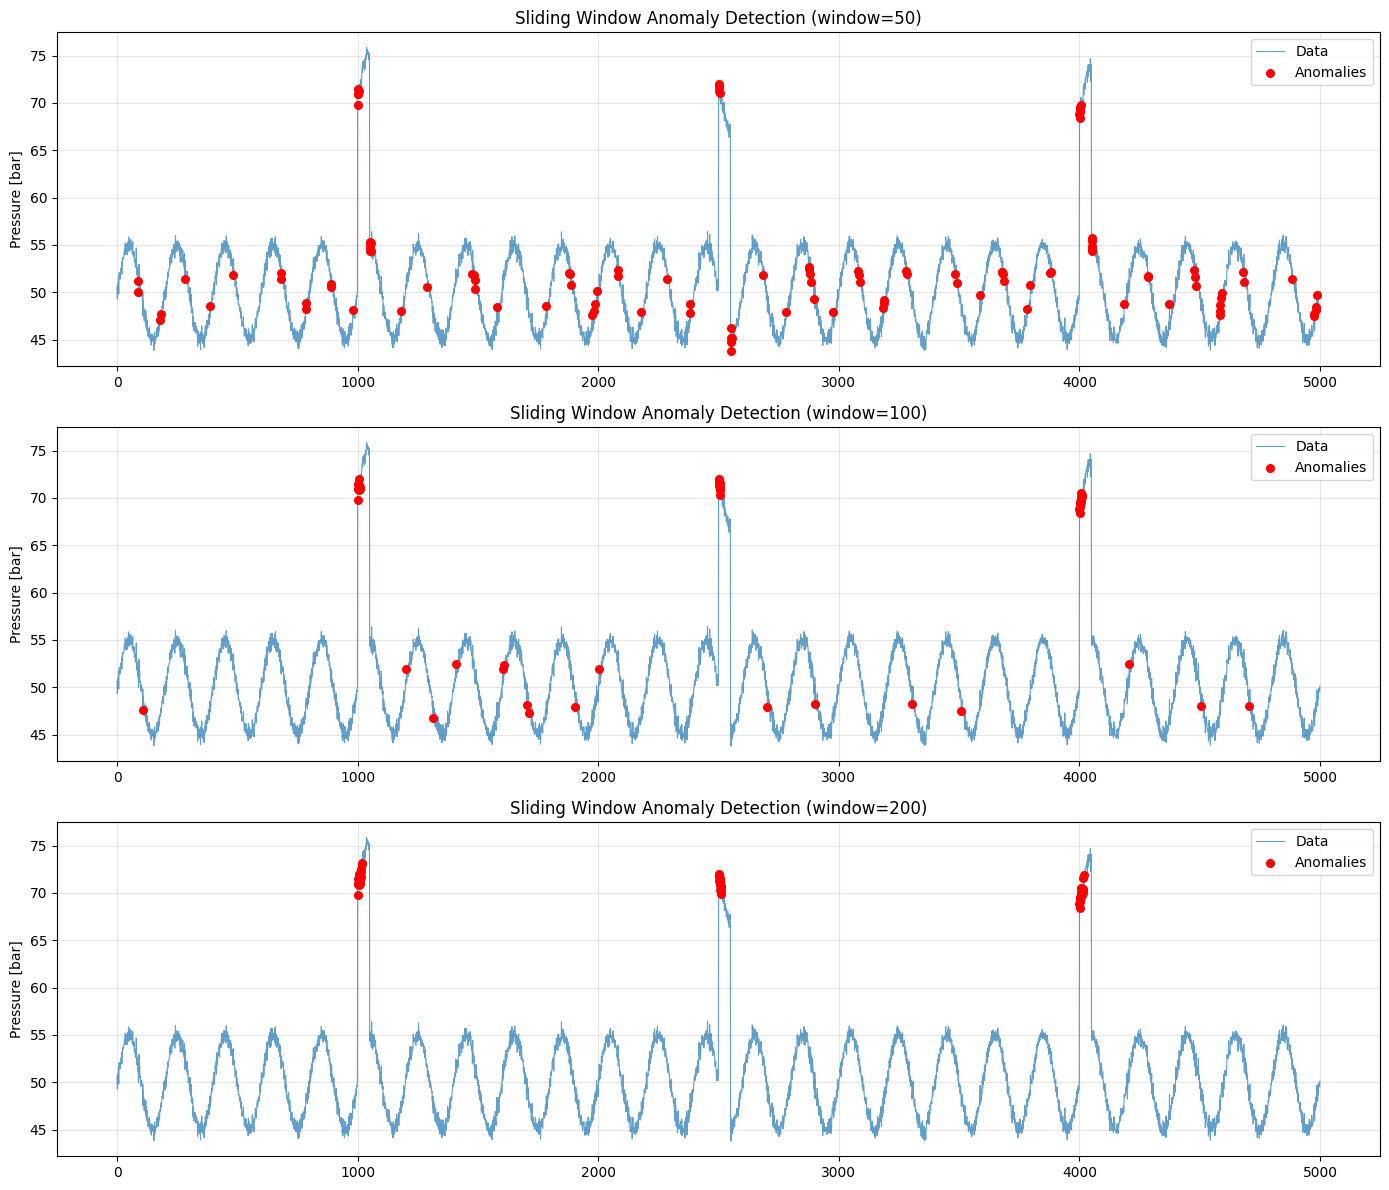

In [12]:
def sliding_window_anomaly(data, window_size=100, threshold=3):
    """
    Detect anomalies using sliding window statistics.
    
    Args:
        data: 1D array of values
        window_size: Size of the sliding window
        threshold: Z-score threshold
    
    Returns:
        Array of anomaly scores for each point
    """
    n = len(data)
    anomaly_scores = np.zeros(n)
    
    for i in range(window_size, n):
        window = data[i-window_size:i]
        mean = np.mean(window)
        std = np.std(window)
        
        if std > 0:
            anomaly_scores[i] = np.abs((data[i] - mean) / std)
    
    return anomaly_scores

# Test sliding window detection
window_sizes = [50, 100, 200]
fig, axes = plt.subplots(len(window_sizes), 1, figsize=(14, 4*len(window_sizes)))

if len(window_sizes) == 1:
    axes = [axes]

for i, window_size in enumerate(window_sizes):
    scores = sliding_window_anomaly(test_data, window_size=window_size, threshold=3)
    anomalies = scores > 3
    
    axes[i].plot(test_data, linewidth=0.8, label='Data', alpha=0.7)
    axes[i].scatter(np.where(anomalies)[0], test_data[anomalies], 
                   color='red', s=30, label='Anomalies', zorder=5)
    axes[i].set_title(f'Sliding Window Anomaly Detection (window={window_size})')
    axes[i].set_ylabel(test_channel)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    print(f"Window size {window_size}: {np.sum(anomalies)} anomalies detected")

plt.tight_layout()
plt.show()

## 9. Summary

In [13]:
print("\n" + "=" * 70)
print("ANOMALY DETECTION TEST SUMMARY")
print("=" * 70)
print(f"✓ Data loaded: {df.shape[0]} samples, {df.shape[1]} channels")
print(f"✓ Test channel: {test_channel}")
print(f"\nStatistical Methods:")
print(f"  - Z-score: {np.sum(anomalies_zscore)} anomalies")
print(f"  - IQR: {np.sum(anomalies_iqr)} anomalies")
print(f"\nSliding Window Methods:")
for window_size in window_sizes:
    scores = sliding_window_anomaly(test_data, window_size=window_size)
    n_anomalies = np.sum(scores > 3)
    print(f"  - Window {window_size}: {n_anomalies} anomalies")
print("=" * 70)


ANOMALY DETECTION TEST SUMMARY
✓ Data loaded: 5000 samples, 5 channels
✓ Test channel: Pressure [bar]

Statistical Methods:
  - Z-score: 150 anomalies
  - IQR: 150 anomalies

Sliding Window Methods:
  - Window 50: 114 anomalies
  - Window 100: 47 anomalies
  - Window 200: 48 anomalies
